In [193]:
import json
import pandas as pd
from collections import Counter

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})


# Read Tweets and Meta Data

In [13]:
tweet_json_file = "./data/1st_run/all_tweets_with_meta.json"
with open(tweet_json_file, 'r') as f:
    long_tweets = json.load(f)

In [58]:
tweets = []
for tweet in long_tweets:
    tweets.append({
        'created_at': tweet['created_at'], 
        'text': tweet['text'],
        'in_reply_to_user_id': tweet['in_reply_to_screen_name'],
        'user': tweet['user']['screen_name'].lower(), 
        'favorite_count': tweet['favorite_count'],
        'retweet_count': tweet['retweet_count']})

# Read Candidate Relations

In [28]:
candidate_jsonlist_file = "./2014_us_gubernatorial_election_candidates_with_twitter.jsonlist"
candidates = []
with open(candidate_jsonlist_file, 'r') as f:
    for line in f:
        candidates.append(json.loads(line))

## Build Opponent Relationship

In [105]:
state_to_candidates = {}
for c in candidates:
    state = c['state']
    if state not in state_to_candidates:
        state_to_candidates[state] = set()
    state_to_candidates[state].add((c['name'].lower(), c['twitter'].lower()))

In [106]:
opponents = {}

# candidate relationship
for c in candidates:
    # key in by twitter handle
    t = c['twitter'].lower()
    if not t:
        continue
    if t not in opponents:
        opponents[t] = set()
        
    state_wide_opponents = state_to_candidates[c['state']]
    for name, twitter in state_wide_opponents:
        if twitter == t:
            continue
        if not twitter:
            continue
            
        opponents[t].add(twitter.lower())
        for name_component in name.split():
            if name_component:
                opponents[t].add(name_component.lower())

# Attack Tweets

In [107]:
attacking = []
for tweet in tweets:
    user = tweet['user']
    oppo = opponents[user]
    text = tweet['text']
    attacking.append(any([o in text.lower() for o in oppo]))
print("{0:.2f}% of tweets are attack tweets".format(100 * attacking.count(True) / len(attacking)))

15.66% of tweets are attack tweets


In [108]:
# get index of these attack tweets
attacking_index = [i for i, a in enumerate(attacking) if a]

In [110]:
for ai in attacking_index[10:20]:
    tweet = tweets[ai]
    user = tweet['user']
    oppo = opponents[user]
    text = tweet['text']
    
    print(text)
    print(oppo)
    print()

My record of support for sexual assault survivors speaks for itself. @GregAbbott_TX can't keep his story straight: http://t.co/oc47w0rdyb
{'gregabbott_tx', 'greg', 'glass', 'kathie', 'kathieglass4tx', 'abbott'}

“@ScottWalker: We're telling ppl what we're for... Our opponent is telling voters what she's against.” I'm tell voters your both clueless.
{'walker', 'mary', 'scott', 'scottwalker', 'burke', 'maryburke_01'}

@WolfForPA has used “Fuzzy math” on his tax plan. See what @PhillyInquirer had to say about that.  #PAGov http://t.co/B9ia7CG3hu
{'wolf', 'tom', 'tomwolfpa'}

Republicans are tired of #BranstadDisasters and ready for #IowasFreshStart http://t.co/TC11vqCBsS
{'branstad', 'terry', 'terrybranstad'}

Today: @WyllieForGov in Orlando for Meet&amp;Greet at @OrlandoBrewing http://t.co/VNFZUhUi82 @MyNews13 @MyFoxOrlando @Scott_Maxwell @adeslatte
{'glennburkett4fl', 'farid', 'rick', 'burkett', 'charliecrist', 'charlie', 'scottforflorida', 'crist', 'scott', 'farid_khavari', 'khavari', 

# Merge Dataset

## + Attacking

In [115]:
for tweet, is_attack in zip(tweets, attacking):
    tweet['is_attack'] = is_attack

## + Geography

In [122]:
candidate_to_state = {}
for c in candidates:
    t = c['twitter'].lower()
    if t:
        candidate_to_state[t] = c['state']
        
for tweet in tweets:
    tweet['state'] = candidate_to_state[tweet['user']]

## + Party

In [203]:
candidate_to_party = {}
for c in candidates:
    t = c['twitter'].lower()
    if t:
        candidate_to_party[t] = c['party']
        
for tweet in tweets:
    tweet['party'] = candidate_to_party[tweet['user']]

## + Incumbency

In [210]:
candidate_to_incumbency = {}
for c in candidates:
    t = c['twitter'].lower()
    if t:
        candidate_to_incumbency[t] = c['incumbency']
        
for tweet in tweets:
    tweet['incumbency'] = candidate_to_incumbency[tweet['user']]

# Attack By States

In [181]:
state_to_attack_count = Counter()
state_to_total_tweets = Counter()

for tweet in tweets:
    is_attack = tweet['is_attack']
    state = tweet['state']
    
    state_to_total_tweets[state] += 1
    
    if is_attack:
        state_to_attack_count[state] += 1

states = list(state_to_total_tweets.keys())        
rates = [state_to_attack_count[state] / state_to_total_tweets[state] for state in states]

df_attack_rate_by_state = pd.DataFrame(index=states, data=rates, columns=["attack_rate"])

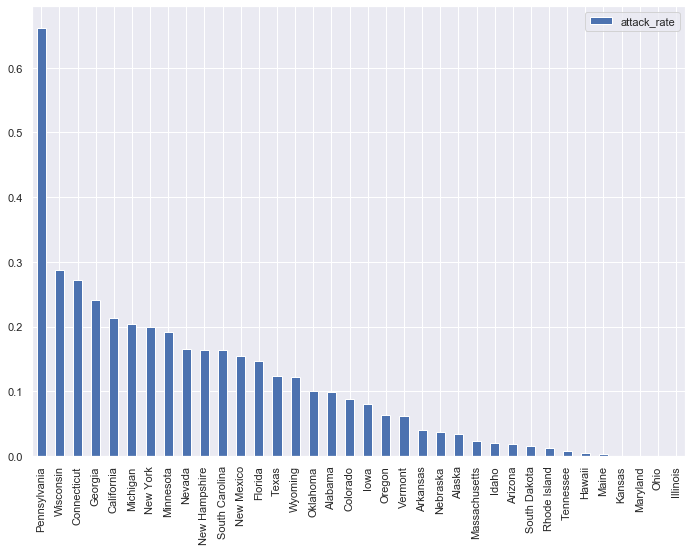

In [194]:
df_attack_rate_by_state.sort_values("attack_rate", ascending=False).plot.bar()

# Attack By Party

In [200]:
party_to_attack_count = Counter()
party_to_total_tweets = Counter()

for tweet in tweets:
    is_attack = tweet['is_attack']
    party = tweet['party']
    
    party_to_total_tweets[party] += 1
    
    if is_attack:
        party_to_attack_count[party] += 1

parties = list(party_to_total_tweets.keys())        
rates = [party_to_attack_count[party] / party_to_total_tweets[party] for party in parties]

df_attack_rate_by_party = pd.DataFrame(index=parties, data=rates, columns=["attack_rate"])

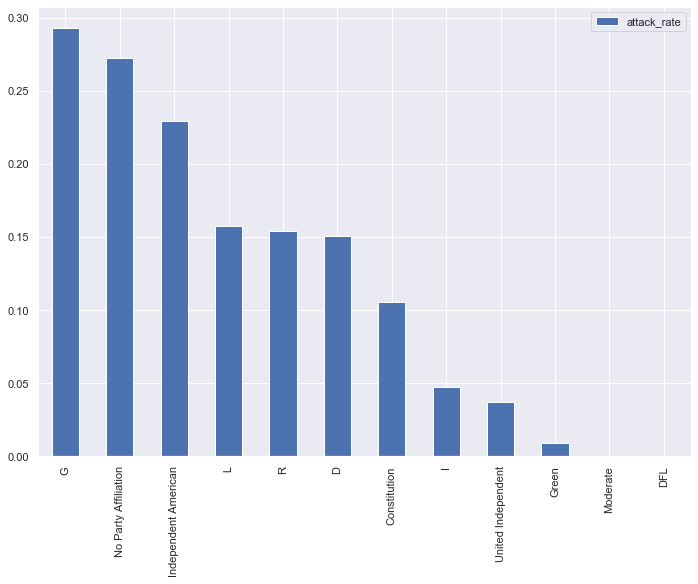

In [201]:
df_attack_rate_by_party.sort_values("attack_rate", ascending=False).plot.bar()

# Attack By Incumbency

In [213]:
incumbency_to_attack_count = Counter()
incumbency_to_total_tweets = Counter()

for tweet in tweets:
    is_attack = tweet['is_attack']
    incumbency = tweet['incumbency']
    
    incumbency_to_total_tweets[incumbency] += 1
    
    if is_attack:
        incumbency_to_attack_count[incumbency] += 1

incumbencies = list(incumbency_to_total_tweets.keys())        
rates = [incumbency_to_attack_count[incumbency] / incumbency_to_total_tweets[incumbency] for incumbency in incumbencies]

df_attack_rate_by_incumbency = pd.DataFrame(index=incumbencies, data=rates, columns=["attack_rate"])

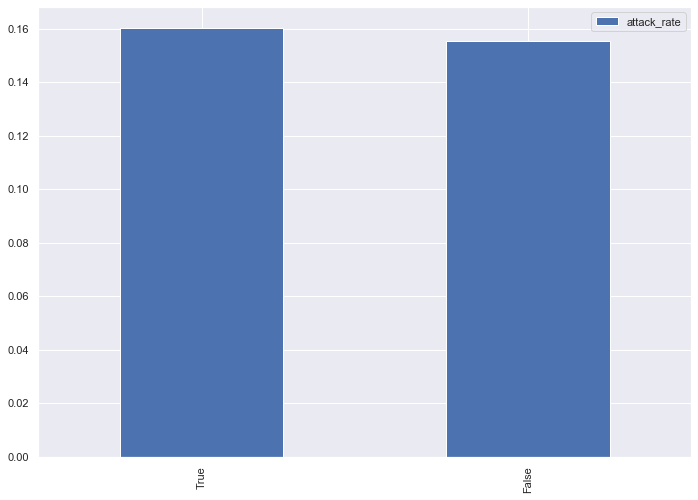

In [215]:
df_attack_rate_by_incumbency.sort_values("attack_rate", ascending=False).plot.bar()